https://www.kaggle.com/competitions/playground-series-s5e5

In [1]:
import pandas as pd
import numpy as np

from itertools import combinations

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.preprocessing import PowerTransformer
from sklearn.decomposition import PCA

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_squared_log_error

import xgboost as xgb
import optuna

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

## Preprocess

In [3]:
CAT_COLS = ['Sex']

TARGET_COL = 'Calories'

DROP_COLS = CAT_COLS + [TARGET_COL, 'id']

NUMS_COLS = df_train.drop(columns=DROP_COLS).columns.tolist()

In [4]:
def sex_prep(df):
    
    df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})
    
    return df

In [5]:
def poly_cols(df):
    
    for col_1, col_2 in list(combinations([x for x in NUMS_COLS], 2)):
        df[col_1 + '_' + col_2] = df[col_1] * df[col_2]

    return df

In [6]:
df_train = sex_prep(df_train)
df_test = sex_prep(df_test)

df_train = poly_cols(df_train)
df_test = poly_cols(df_test)

In [7]:
# update nums cols
NUMS_COLS = df_train.drop(columns=DROP_COLS).columns.tolist()

#### transformers

In [61]:
df_tr_train = df_train.copy()
df_tr_test = df_test.copy()

In [62]:
# box-cox transform
tr_box_cox = PowerTransformer(method='box-cox', standardize=True)

df_tr_train.loc[:, NUMS_COLS] = tr_box_cox.fit_transform(df_tr_train[NUMS_COLS])
df_tr_test.loc[:, NUMS_COLS] = tr_box_cox.transform(df_tr_test[NUMS_COLS])

In [63]:
# PCA features
tr_pca = PCA(n_components=0.99)
tr_pca.fit(df_tr_train[NUMS_COLS])

df_train.loc[:, ['PC_'+str(x+1) for x in range(tr_pca.n_components_)]] = tr_pca.transform(df_tr_train[NUMS_COLS])
df_test.loc[:, ['PC_'+str(x+1) for x in range(tr_pca.n_components_)]] = tr_pca.transform(df_tr_test[NUMS_COLS])

In [64]:
# Train cols
TRAIN_COLS = CAT_COLS + ['PC_'+str(x+1) for x in range(tr_pca.n_components_)]

In [65]:
# target coll transform
if True:
    target_tr = PowerTransformer(method='box-cox', standardize=False)
    df_train.loc[:, [TARGET_COL]] =  target_tr.fit_transform(df_train[[TARGET_COL]].values)

## Train model

In [66]:
X_train, X_test, y_train, y_test = train_test_split(df_train[TRAIN_COLS],
                                                    df_train[TARGET_COL],
                                                    test_size=0.25,
                                                    random_state=42,
                                                    shuffle=True)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [67]:
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [74]:
def rmsle_transform(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(target_tr.inverse_transform(y_true.values.reshape(-1,1)),
                                          target_tr.inverse_transform(y_pred.reshape(-1,1))))

In [75]:
def objective(trial):
    
    params = {
        'objective': 'reg:squarederror', # squarederror squaredlogerror
        'eval_metric': 'rmsle',
        'early_stopping_rounds': 50,
        
        'random_state': 42,
        'device':      'cuda',
        
        'n_estimators': trial.suggest_int('n_estimators', 200, 10000, step=100),
        'max_depth': trial.suggest_int('max_depth', 3, 14),
        
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'min_child_weight': trial.suggest_float('min_child_weight', 1e-3, 10, log=True),
        
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),
        
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        
    }

    rmsle_scores = []
    best_iters = []
    
    for train_idx, valid_idx in kf.split(X_train):
        
        X_train_t, X_valid = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_train_t, y_valid = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        model = xgb.XGBRegressor(**params)
        model.fit(
            X_train_t,
            y_train_t,
            eval_set=[(X_valid, y_valid)],
            verbose=False
        )

        preds = model.predict(X_valid)
        
        rmsle_scores.append(rmsle_transform(y_valid, preds))
        best_iters.append(model.n_estimators)
        

    trial.set_user_attr('best_iters', best_iters)
    trial.set_user_attr('scores_user', rmsle_scores)
    
    return np.mean(rmsle_scores)

In [76]:
study = optuna.create_study(direction='minimize', pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=100, show_progress_bar=True)

[I 2025-05-09 15:23:19,835] A new study created in memory with name: no-name-621cb0ed-0e29-4150-acfa-0cca3cdd9890


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-05-09 15:24:54,915] Trial 0 finished with value: 0.12698800769135352 and parameters: {'n_estimators': 2700, 'max_depth': 5, 'learning_rate': 0.0019374736674254924, 'gamma': 4.178985165233997, 'min_child_weight': 0.06353620795165481, 'reg_alpha': 2.020105296803857, 'reg_lambda': 4.532011002275615, 'subsample': 0.8638561057515239, 'colsample_bytree': 0.6040401405103923}. Best is trial 0 with value: 0.12698800769135352.
[I 2025-05-09 15:25:22,022] Trial 1 finished with value: 0.07100958918547906 and parameters: {'n_estimators': 900, 'max_depth': 5, 'learning_rate': 0.18660996663774534, 'gamma': 0.10105304709549401, 'min_child_weight': 0.10832583315126715, 'reg_alpha': 2.6116312829130726, 'reg_lambda': 4.106234818620652, 'subsample': 0.7588649079076061, 'colsample_bytree': 0.7638433855453373}. Best is trial 1 with value: 0.07100958918547906.
[I 2025-05-09 15:25:32,260] Trial 2 finished with value: 0.07473470900502896 and parameters: {'n_estimators': 2600, 'max_depth': 6, 'learning_

[I 2025-05-09 15:44:27,798] Trial 20 finished with value: 0.07566310247864516 and parameters: {'n_estimators': 1500, 'max_depth': 9, 'learning_rate': 0.0045413551893012365, 'gamma': 1.2899906715700802, 'min_child_weight': 0.8782527435753081, 'reg_alpha': 0.031689297986811304, 'reg_lambda': 2.9528824180503133, 'subsample': 0.5384238563193231, 'colsample_bytree': 0.704597415426911}. Best is trial 11 with value: 0.06974170357097616.
[I 2025-05-09 15:46:00,519] Trial 21 finished with value: 0.06980481162208528 and parameters: {'n_estimators': 1800, 'max_depth': 8, 'learning_rate': 0.01798882645369565, 'gamma': 0.030377611400457694, 'min_child_weight': 0.4144654474223754, 'reg_alpha': 0.6836072995159603, 'reg_lambda': 2.9020140589260217, 'subsample': 0.6143025862124437, 'colsample_bytree': 0.7314005458627907}. Best is trial 11 with value: 0.06974170357097616.
[I 2025-05-09 15:47:10,615] Trial 22 finished with value: 0.07105895143662269 and parameters: {'n_estimators': 1800, 'max_depth': 8, 

[I 2025-05-09 16:16:50,509] Trial 39 finished with value: 0.07057812033445952 and parameters: {'n_estimators': 900, 'max_depth': 8, 'learning_rate': 0.014444515865025785, 'gamma': 1.1604448453074951, 'min_child_weight': 0.046755351135240396, 'reg_alpha': 2.4937680092801946, 'reg_lambda': 1.5765908499793562, 'subsample': 0.706525341641579, 'colsample_bytree': 0.9478601159629862}. Best is trial 35 with value: 0.0695462281626589.
[I 2025-05-09 16:17:56,899] Trial 40 finished with value: 0.07141264598163427 and parameters: {'n_estimators': 1700, 'max_depth': 6, 'learning_rate': 0.007200442097734282, 'gamma': 1.5673446228455004, 'min_child_weight': 0.00530190024638963, 'reg_alpha': 2.8942286416507796, 'reg_lambda': 1.2828700908261486, 'subsample': 0.8488306354771089, 'colsample_bytree': 0.8521649805198676}. Best is trial 35 with value: 0.0695462281626589.
[I 2025-05-09 16:20:01,178] Trial 41 finished with value: 0.06967319151064563 and parameters: {'n_estimators': 1700, 'max_depth': 9, 'lea

[I 2025-05-09 16:40:08,557] Trial 59 finished with value: 0.5890626684712562 and parameters: {'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.0037305839826995498, 'gamma': 0.5416850118877592, 'min_child_weight': 0.05134043334697601, 'reg_alpha': 1.7585768627314837, 'reg_lambda': 4.1864653536803775, 'subsample': 0.6882263226894293, 'colsample_bytree': 0.9803417380246909}. Best is trial 35 with value: 0.0695462281626589.
[I 2025-05-09 16:42:08,200] Trial 60 finished with value: 0.07023074098700613 and parameters: {'n_estimators': 1800, 'max_depth': 9, 'learning_rate': 0.01845203288625141, 'gamma': 0.15257374190672723, 'min_child_weight': 0.24933093609244658, 'reg_alpha': 2.0755347566953937, 'reg_lambda': 2.7623883558445588, 'subsample': 0.6661768501696513, 'colsample_bytree': 0.5241141350666132}. Best is trial 35 with value: 0.0695462281626589.
[I 2025-05-09 16:43:10,435] Trial 61 finished with value: 0.069608135175504 and parameters: {'n_estimators': 1900, 'max_depth': 7, 'learn

[I 2025-05-09 17:00:55,987] Trial 79 finished with value: 0.07020291564514246 and parameters: {'n_estimators': 2300, 'max_depth': 10, 'learning_rate': 0.02100996801730911, 'gamma': 0.3561710808076389, 'min_child_weight': 0.4500771928667654, 'reg_alpha': 3.2179493573779414, 'reg_lambda': 3.278536377500865, 'subsample': 0.6978751769851064, 'colsample_bytree': 0.9224389930765643}. Best is trial 35 with value: 0.0695462281626589.
[I 2025-05-09 17:01:47,354] Trial 80 finished with value: 0.07065674867978754 and parameters: {'n_estimators': 1800, 'max_depth': 7, 'learning_rate': 0.01595213957384593, 'gamma': 1.0817879122189087, 'min_child_weight': 0.09745780453164761, 'reg_alpha': 2.720135915216725, 'reg_lambda': 2.2713430764679545, 'subsample': 0.7456903939361389, 'colsample_bytree': 0.9524623457101907}. Best is trial 35 with value: 0.0695462281626589.
[I 2025-05-09 17:02:54,506] Trial 81 finished with value: 0.06960487068958726 and parameters: {'n_estimators': 1900, 'max_depth': 7, 'learni

[I 2025-05-09 17:23:40,915] Trial 99 finished with value: 0.07061113926972344 and parameters: {'n_estimators': 2600, 'max_depth': 8, 'learning_rate': 0.006602112819764659, 'gamma': 1.8495845432193025, 'min_child_weight': 0.03658420000786577, 'reg_alpha': 2.377666929715676, 'reg_lambda': 1.8945578150476434, 'subsample': 0.5134178501299284, 'colsample_bytree': 0.9237206895356982}. Best is trial 98 with value: 0.06952294869284917.


In [77]:
print(study.best_trial.values)
print(study.best_trial.params)
print(study.best_trial.user_attrs)

[0.06952294869284917]
{'n_estimators': 2100, 'max_depth': 8, 'learning_rate': 0.00861832273102733, 'gamma': 0.09705010158684463, 'min_child_weight': 0.08963930431913573, 'reg_alpha': 2.4119891296601046, 'reg_lambda': 1.924369918235466, 'subsample': 0.5521818864563143, 'colsample_bytree': 0.9883149070759112}
{'best_iters': [2100, 2100, 2100, 2100, 2100], 'scores_user': [0.06946322834241185, 0.06869514610994244, 0.06931450252274238, 0.07058151119536468, 0.06956035529378449]}


In [111]:
def get_xgb_model():
    
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        eval_metric='rmsle',
        #early_stopping_rounds=50,
        
        random_state=42,
        device='cuda',
        
        n_estimators=4141,
        max_depth= 8,
        
        learning_rate= 0.00861832273102733,
        gamma= 0.09705010158684463,        
        min_child_weight= 0.08963930431913573,
        
        reg_alpha= 2.4119891296601046,
        reg_lambda= 1.924369918235466,
        
        subsample= 0.5521818864563143,
        colsample_bytree= 0.9883149070759112
    )
    
    return model

In [112]:
# model
medel_xgb = get_xgb_model()
medel_xgb.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    verbose=100
)

[0]	validation_0-rmsle:0.51575
[100]	validation_0-rmsle:0.30434
[200]	validation_0-rmsle:0.17667
[300]	validation_0-rmsle:0.10468
[400]	validation_0-rmsle:0.06842
[500]	validation_0-rmsle:0.05461
[600]	validation_0-rmsle:0.04915
[700]	validation_0-rmsle:0.04727
[800]	validation_0-rmsle:0.04629
[900]	validation_0-rmsle:0.04582
[1000]	validation_0-rmsle:0.04553
[1100]	validation_0-rmsle:0.04534
[1200]	validation_0-rmsle:0.04521
[1300]	validation_0-rmsle:0.04511
[1400]	validation_0-rmsle:0.04502
[1500]	validation_0-rmsle:0.04496
[1600]	validation_0-rmsle:0.04490
[1700]	validation_0-rmsle:0.04485
[1800]	validation_0-rmsle:0.04481
[1900]	validation_0-rmsle:0.04478
[2000]	validation_0-rmsle:0.04474
[2100]	validation_0-rmsle:0.04472
[2200]	validation_0-rmsle:0.04469
[2300]	validation_0-rmsle:0.04467
[2400]	validation_0-rmsle:0.04465
[2500]	validation_0-rmsle:0.04463
[2600]	validation_0-rmsle:0.04460
[2700]	validation_0-rmsle:0.04458
[2800]	validation_0-rmsle:0.04457
[2900]	validation_0-rmsle:

In [123]:
preds = medel_xgb.predict(X_test)

y_test_tr = target_tr.inverse_transform(y_test.values.reshape(-1,1)).reshape(1,-1)[0]
y_preds_tr = target_tr.inverse_transform(preds.reshape(-1,1)).reshape(1,-1)[0]
resudials = y_test_tr - y_preds_tr

In [138]:
print('R2', r2_score(y_test_tr, y_preds_tr))
print('RMSE', mean_squared_error(y_test_tr, y_preds_tr)**0.5)
print('MAE', mean_absolute_error(y_test_tr, y_preds_tr))
print('RMSLE', mean_squared_log_error(y_test_tr, y_preds_tr)**0.5)

R2 0.9945619775926664
RMSE 4.592106810672207
MAE 2.8979985499976477
RMSLE 0.06951047309725174


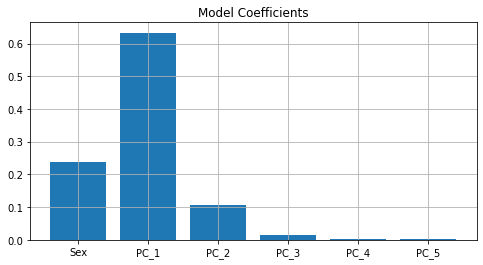

In [135]:
# model coefs
plt.figure(figsize=(8, 4))
plt.bar(medel_xgb.feature_names_in_, medel_xgb.feature_importances_)
plt.title('Model Coefficients')
plt.grid(True)
plt.show()

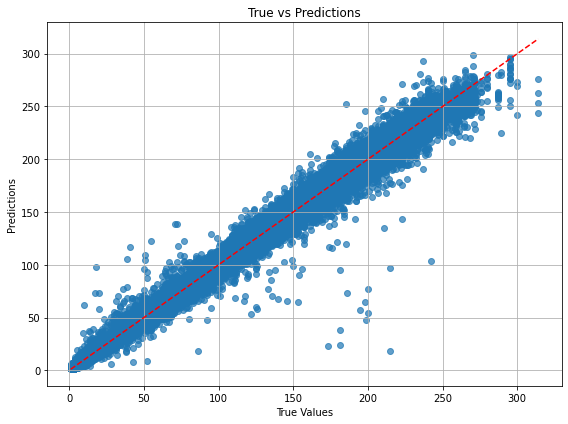

In [134]:
# predict vs fact
plt.figure(figsize=(8, 6))
plt.scatter(y_test_tr, y_preds_tr, alpha=0.7)
plt.plot([y_test_tr.min(), y_test_tr.max()], [y_test_tr.min(), y_test_tr.max()], 'r--')
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("True vs Predictions")
plt.grid(True)
plt.tight_layout()
plt.show()

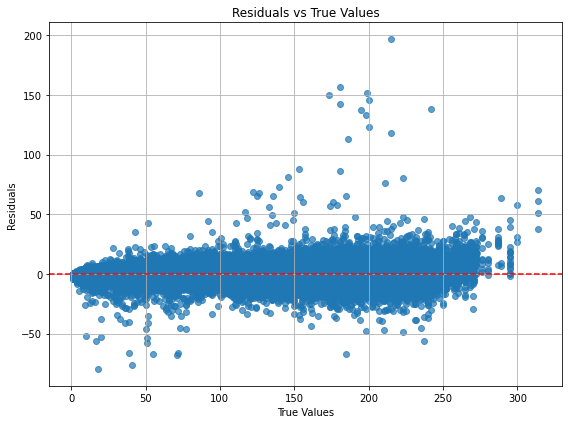

In [136]:
# resudials
plt.figure(figsize=(8, 6))
plt.scatter(y_test_tr, resudials, alpha=0.7)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("True Values")
plt.ylabel("Residuals")
plt.title("Residuals vs True Values")
plt.grid(True)
plt.tight_layout()
plt.show()

## Predict

In [148]:
# refit
model_fin = get_xgb_model()
model_fin.fit(df_train[TRAIN_COLS],df_train[TARGET_COL]);

In [152]:
df_test[TARGET_COL] = model_fin.predict(df_test[TRAIN_COLS])
df_test[TARGET_COL] = target_tr.inverse_transform(df_test[TARGET_COL].values.reshape(-1,1)).reshape(1,-1)[0]

In [155]:
df_test[['id', TARGET_COL]].to_csv('first_xgb_model.csv', index=False)